# Práctica 2: Determinación de Tipos de Estrellas
Autores: Rodrigo Maroto Caño y Rodrigo Toldos Frutos  
Correos electrónicos: 100454455@alumnos.uc3m.es - 100454470@alumnos.uc3m.es   
Usuarios en GitHub: @RodrigoMaroto (owner) y @100454470   
Link del repositorio: https://github.com/RodrigoMaroto/Practica2-ML/

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

np.random.seed(454455)

## 1. Implementación de K-means

In [2]:
def kmeans(X, n_clusters=2, max_iters=100):
        centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
        for _ in range(max_iters):
            distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)

            new_centroids = np.empty_like(centroids)
            for i in range(n_clusters):
                new_centroids[i] = X[labels == i].mean(axis=0)
            
            if np.allclose(new_centroids, centroids):
                break
            centroids = new_centroids
        return labels

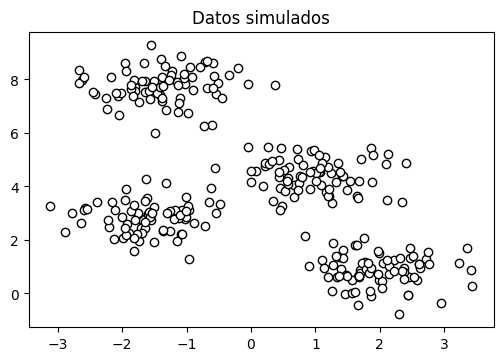

In [3]:
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

In [4]:
X_scaled = scale(X)

In [5]:
%%timeit
y_predict = kmeans(X_scaled, 4)


1.83 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=42)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=4, n_init=25, random_state=42)

In [7]:
%%timeit
y_predict = modelo_kmeans.predict(X=X_scaled)

278 µs ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
y_predict = kmeans(X_scaled, 4)

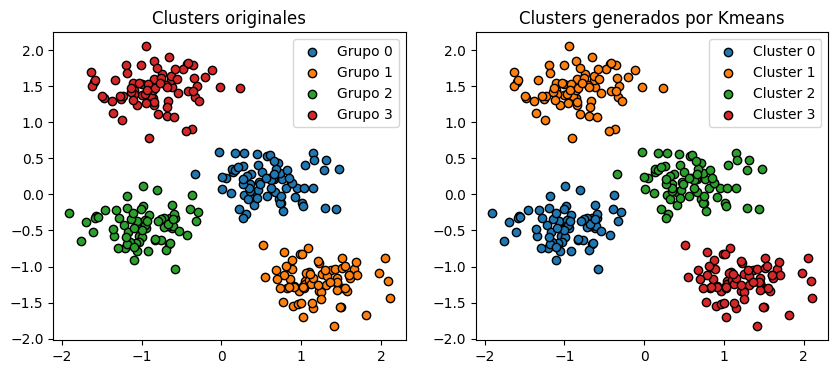

In [9]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

## 2. Codificación de variables

lectura de datos

In [32]:
df = pd.read_csv("stars_data.csv")


### Primera Opción: OneHotEncoding

In [20]:
# Vamos a utilizar el OneHotEncoder de scikit para las variables categóricas. Ponemos sparse_output = False para que se guarden los valores
# que son 0 también.

enc = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform = 'pandas')
new_col_color = enc.fit_transform(df[['Color']])
new_col_sc = enc.fit_transform(df[['Spectral_Class']])

X_ohe = pd.concat([df, new_col_color, new_col_sc], axis = 1)
X_ohe.drop(columns = ['Color', 'Spectral_Class'], inplace = True)
features = X_ohe.columns


In [12]:
X_ohe = scale(X_ohe)

pca = PCA(n_components=2)
X_ohe_pca = pca.fit_transform(X_ohe)

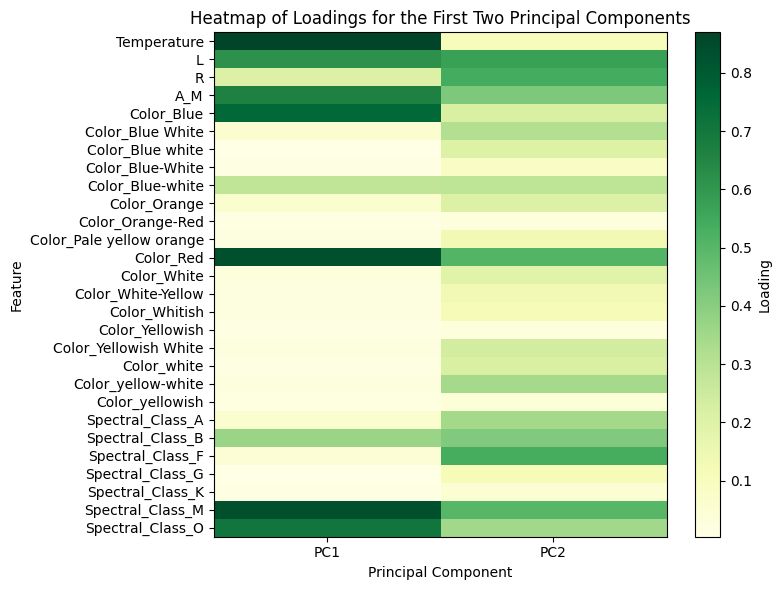

In [28]:
loadings = np.abs(pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2]))

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index= features)

# Plot heatmap of loadings
plt.figure(figsize=(8, 6))
plt.title('Heatmap of Loadings for the First Two Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.imshow(loadings_df, cmap='YlGn', aspect='auto')
plt.colorbar(label='Loading')
plt.xticks(ticks=np.arange(len(loadings_df.columns)), labels=loadings_df.columns)
plt.yticks(ticks=np.arange(len(loadings_df.index)), labels=loadings_df.index)
plt.tight_layout()
plt.show()

### Segunda Opción: Variable Ordinal

Como se indica en el enunciado, el color está asociado a la cantidad de energía, y algo parecido sucede con la clase espectral. Por tanto, puede tener sentido utilizar estas variables como ordinales, con el fin de representar una cercanía mayor entre dos cantidades de energía parecidas. Con OneHotEncoding no conservamos estas relaciones, ya que se utilizan como columnas independientes. Como se puede ver en la imagen, podemos establecer un orden atendiendo a la temperatura.


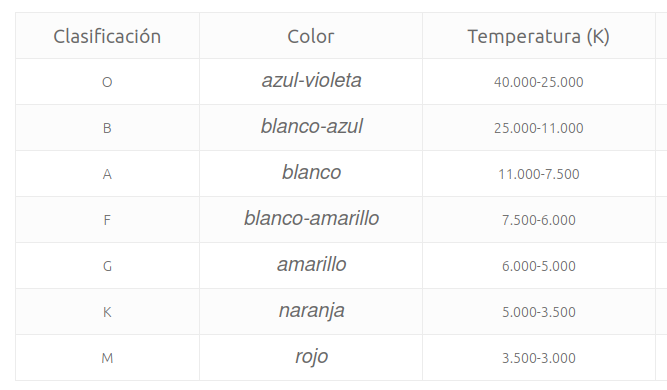

In [33]:
# Primero vamos a ver qué colores hay 
#print(df['Color'].unique())

#['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
#'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
#'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
#'Blue-White']

# Creamos un diccionario para sustituir esos nombres por valores que representen el orden

color_values = {"Red": 1, "Orange-Red": 2, "Orange": 3, "Pale yellow orange": 4, "yellowish": 5, "Yellowish": 5, "White-Yellow": 6,
                "yellow-white": 6,"Yellowish White": 6,"White": 7, "white": 7, "Whitish": 7, "Blue white": 8,"Blue White": 8,  
                "Blue-white": 8, "Blue-White": 8, "Blue": 9,
                }

df['Color'] = df['Color'].map(color_values)

# Hacemos lo mismo con la clase espectral

#print(df['Spectral_Class'].unique())
# ['M' 'B' 'A' 'F' 'O' 'K' 'G']

sc_values = {"M": 1, "K": 2, "G":3, "F":4, "A":5, "B":6, "O":7}
df['Spectral_Class'] = df['Spectral_Class'].map(sc_values)
features = df.columns


In [34]:
X_ord = scale(df)

pca = PCA(n_components=2)
X_ord_pca = pca.fit_transform(X_ord)

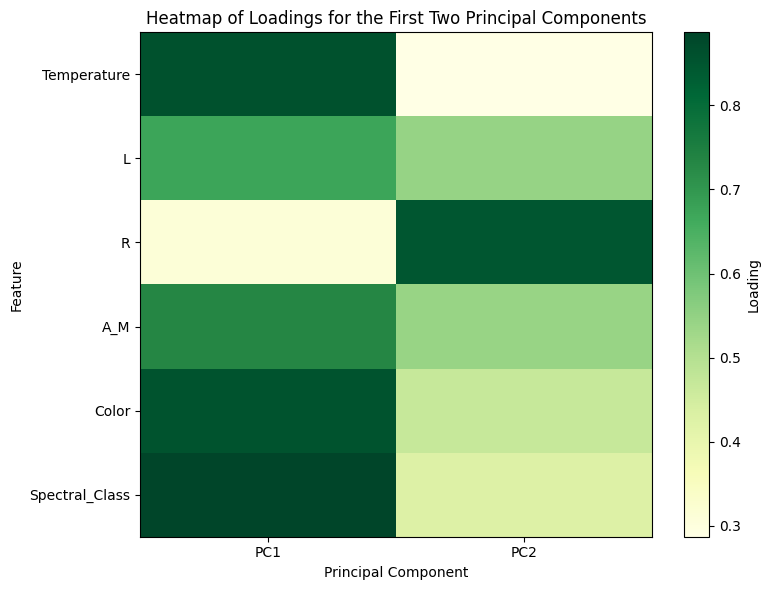

In [36]:
loadings = np.abs(pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2]))

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index= features)

# Plot heatmap of loadings
plt.figure(figsize=(8, 6))
plt.title('Heatmap of Loadings for the First Two Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.imshow(loadings_df, cmap='YlGn', aspect='auto')
plt.colorbar(label='Loading')
plt.xticks(ticks=np.arange(len(loadings_df.columns)), labels=loadings_df.columns)
plt.yticks(ticks=np.arange(len(loadings_df.index)), labels=loadings_df.index)
plt.tight_layout()
plt.show()

## 3. Algoritmos de Clustering

### K-means
En primer lugar, es necesario determinar el número optimo de clusters.

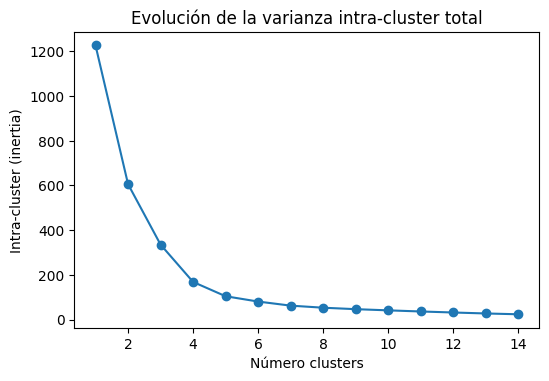

In [60]:

# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_ord_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

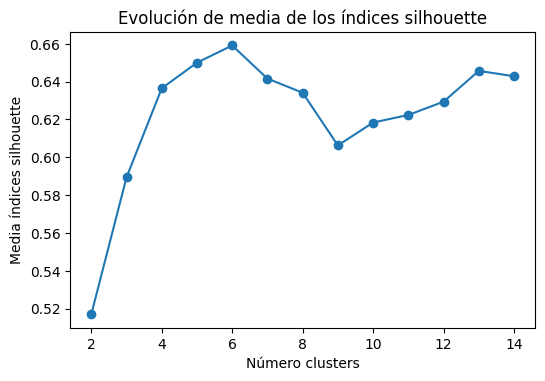

In [61]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_ord_pca)
    silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [62]:
modelo_kmeans = KMeans(n_clusters=6, random_state=100454455)
y_predict = modelo_kmeans.fit_predict(X_ord_pca)

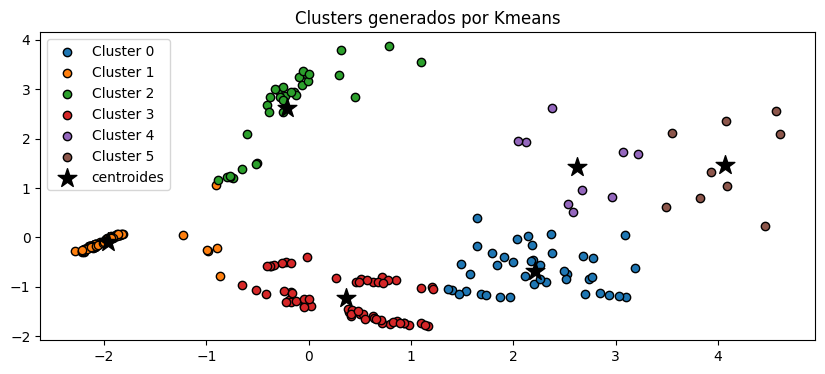

In [63]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 4))


for i in np.unique(y_predict):
    ax.scatter(
        x = X_ord_pca[y_predict == i, 0],
        y = X_ord_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

### DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


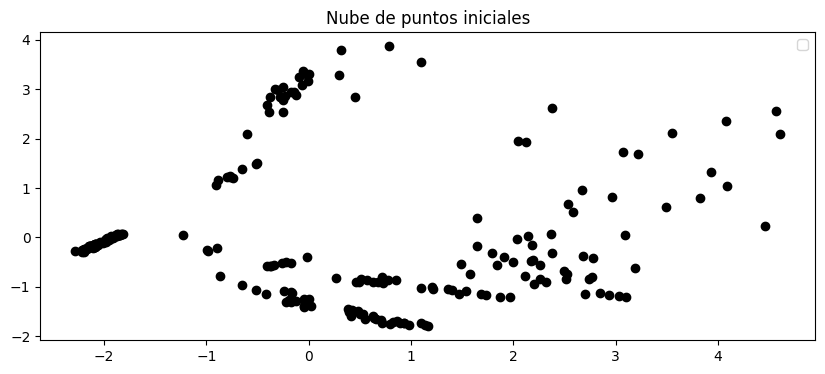

In [55]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ord_pca[:, 0],
    y = X_ord_pca[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

In [52]:
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X_ord_pca)

DBSCAN(eps=0.2)

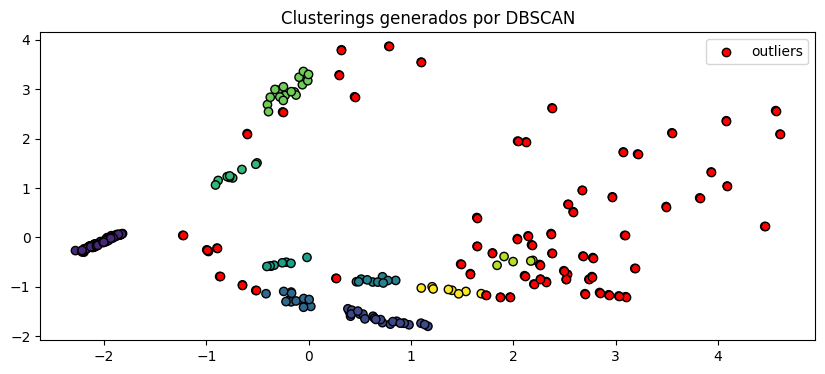

In [59]:
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ord_pca[:, 0],
    y = X_ord_pca[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_ord_pca[labels == -1, 0],
    y = X_ord_pca[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [57]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 9
Número de outliers encontrados: 65


### Comparación de resultados

## 4. Comparación de codificación de variables categóricas 

Realizamos los mismos entrenamientos que en el apartado 3, usando los datos con One Hot Encoding.

### K-means
En primer lugar, es necesario determinar el número optimo de clusters.

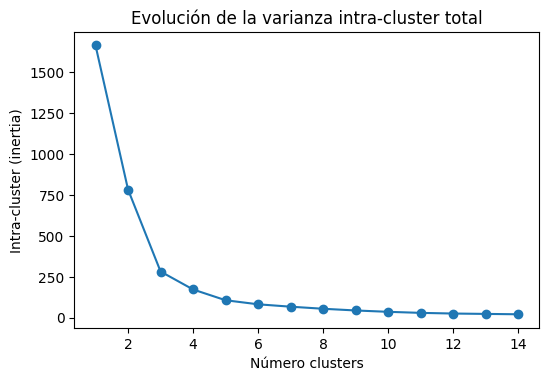

In [64]:

# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_ohe_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

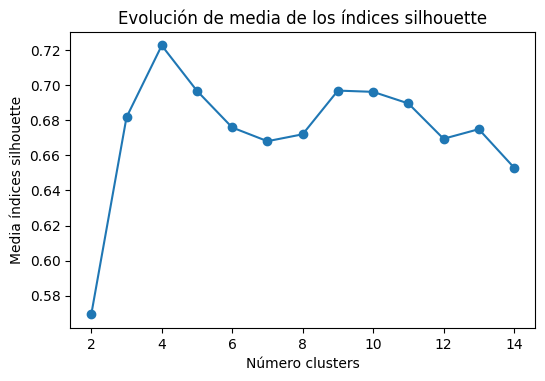

In [65]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_ohe_pca)
    silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [72]:
modelo_kmeans = KMeans(n_clusters=4, random_state=100454455)
y_predict = modelo_kmeans.fit_predict(X_ohe_pca)

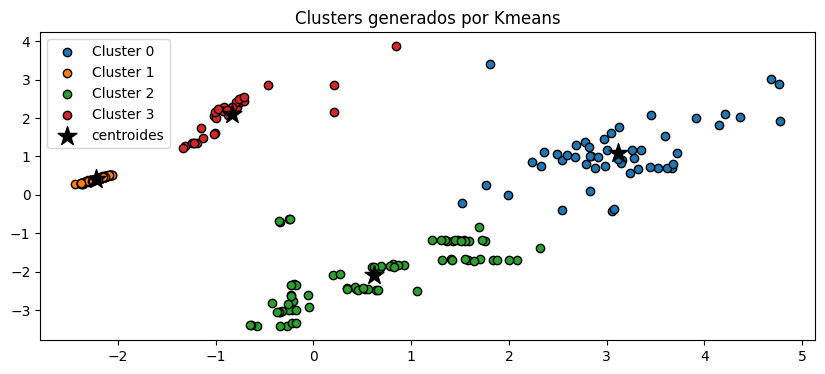

In [73]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 4))


for i in np.unique(y_predict):
    ax.scatter(
        x = X_ohe_pca[y_predict == i, 0],
        y = X_ohe_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

### DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


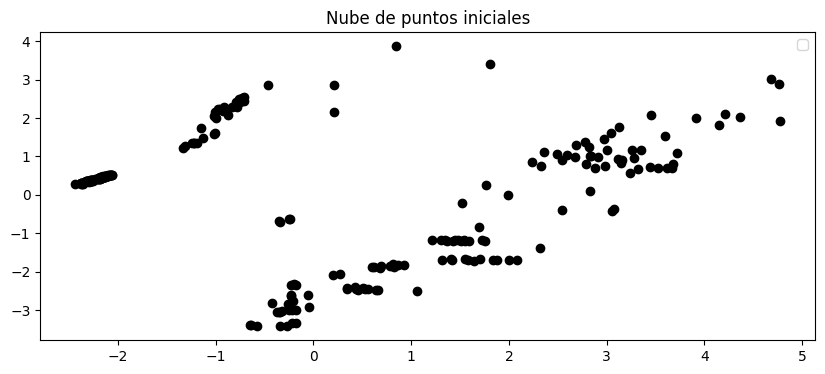

In [68]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ohe_pca[:, 0],
    y = X_ohe_pca[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

In [69]:
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X_ohe_pca)

DBSCAN(eps=0.2)

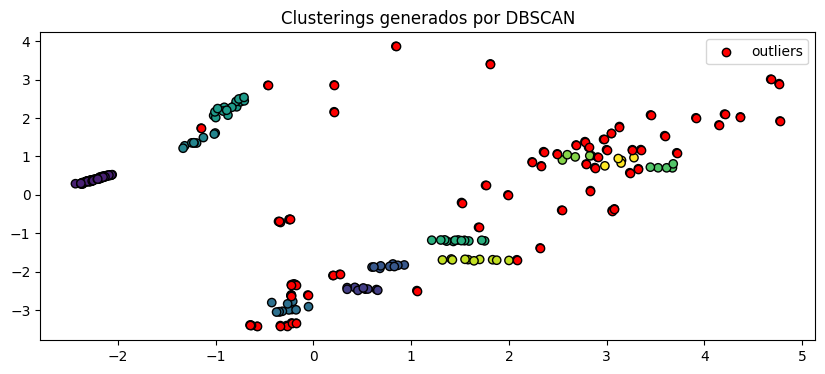

In [70]:
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ohe_pca[:, 0],
    y = X_ohe_pca[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_ohe_pca[labels == -1, 0],
    y = X_ohe_pca[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [71]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 11
Número de outliers encontrados: 64
